In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
images_path='/kaggle/input/image-dataset/images 2'
masks_path='/kaggle/input/masks-dataset/masks'

In [3]:
import os
from PIL import Image

In [4]:
images_dir=os.listdir(images_path)
masks_dir=os.listdir(masks_path)

In [5]:
name=images_dir[0]

In [6]:
name

'245_HC.png'

In [7]:
masks_dir[0]

'492_HC_Annotation.png'

In [8]:
def rename_file(name):
    new_name=""
    for i in range(len(name)):
        if name[i]!='.':
            new_name=new_name+name[i]
        else:
            new_name+='_Annotation'
            break
    new_name+='.png'
    return new_name

In [9]:
images=[Image.open(os.path.join(images_path,filename)) for filename in images_dir]


In [10]:
masks = []
for filename in images_dir:
    if filename=='desktop.ini':
        continue;
    try:
        new_filename=rename_file(filename)
        image_path = os.path.join(masks_path, new_filename)
        image = Image.open(image_path)
        masks.append(image)
    except Exception as e:
        print(f"Error opening image '{filename}': {e}")

In [11]:
len(masks)

622

In [12]:
# combine the image and its coressponding marks 
combine_dataset=[(image,mask) for image,mask in zip(images,masks)]

In [13]:
from torchvision import transforms

In [14]:
# Define transformations for augmentation of image
preprocess = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [15]:
import torch

In [16]:
# transform the image and mask
image_tensor=torch.stack([preprocess(image) for image,_ in combine_dataset])

In [17]:
image_tensor.shape

torch.Size([622, 1, 256, 256])

In [18]:
mask_tensor=torch.stack([preprocess(mask) for _,mask in combine_dataset])

In [19]:
mask_tensor.shape

torch.Size([622, 1, 256, 256])

In [20]:
from torch.utils.data import DataLoader, random_split

In [21]:
train_img_size=int(0.9*len(image_tensor))
val_img_size=len(image_tensor)-train_img_size
train_mask_size=int(0.9*len(mask_tensor))
val_mask_size=len(mask_tensor)-train_mask_size


In [22]:
train_image,val_image=random_split(image_tensor,[train_img_size,val_img_size])
train_mask,val_mask=random_split(mask_tensor,[train_mask_size,val_mask_size])

In [23]:
train_image_dataloader=DataLoader(train_image,batch_size=16,shuffle=False)
train_mask_dataloader=DataLoader(train_mask,batch_size=16,shuffle=False)
val_image_dataloader=DataLoader(val_image,batch_size=16,shuffle=False)
val_mask_dataloader=DataLoader(val_mask,batch_size=16,shuffle=False)

In [24]:

import torch.nn as nn
import torchvision.transforms.functional as tf

In [25]:
# define the model architecture
class DoubleConv(nn.Module):
    def __init__(self,in_channels,out_channels):
        super().__init__()
        self.conv=nn.Sequential(
            nn.Conv2d(in_channels,out_channels,kernel_size=3,stride=1,padding=1,bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels,out_channels,kernel_size=3,stride=1,padding=1,bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self,x):
        return self.conv(x)

class Unet(nn.Module):
    def __init__(self,in_channels=1,out_channels=1,features=[64,128,256,512]):
        super().__init__()
        
        self.ups=nn.ModuleList()
        self.downs=nn.ModuleList()
        self.pool=nn.MaxPool2d(kernel_size=2,stride=2)
        
        # down part of Unet
        for feature in features:
            # in_channels and out_channels are store in features list
            self.downs.append(DoubleConv(in_channels,feature))
            in_channels=feature
       
        # ups part of Unet
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(feature*2,feature,kernel_size=2,stride=2)
            )
            self.ups.append(DoubleConv(feature*2,feature))

        self.bottleneck=DoubleConv(features[-1],features[-1]*2)
        self.final_conv=nn.Conv2d(features[0],out_channels,kernel_size=1)
    
    def forward(self,x):
        
        skip_connections=[]
        
        for down in self.downs:
            x=down(x)
            skip_connections.append(x)
            x=self.pool(x)
        
        x=self.bottleneck(x)
        skip_connections=skip_connections[::-1]
        
        for i in range(0,len(self.ups),2):
            x=self.ups[i](x)
            skip_connection=skip_connections[i//2]
            if x.shape!=skip_connection.shape:
                x=tf.resize(x,skip_connection.shape[2:])
                
            concat_skip=torch.cat((skip_connection,x),dim=1)
            x=self.ups[i+1](concat_skip)
        
        return self.final_conv(x)     

In [26]:
device=  'cuda' if torch.cuda.is_available() else 'cpu'

In [27]:
device

'cuda'

In [28]:
model=Unet(in_channels=1,out_channels=1)

In [29]:
model=model.to(device)

In [30]:
image_=image_tensor[9][0].unsqueeze(0)
image_.shape

torch.Size([1, 256, 256])

In [31]:
# for image, mask in zip(train_image_dataloader,train_mask_dataloader):
#     print(mask.shape)

In [32]:
image_tensor[0][0].unsqueeze(0).unsqueeze(0).shape

torch.Size([1, 1, 256, 256])

In [33]:
import torchvision.transforms as transforms

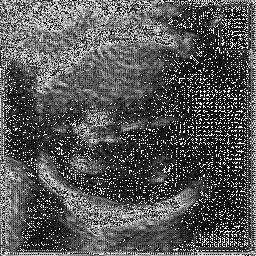

In [34]:
out=model(image_tensor[0][0].unsqueeze(0).unsqueeze(0).to(device))
to_pil=transforms.ToPILImage()
pil_image = to_pil(out.squeeze(0))
pil_image # output image of the model 

In [35]:
import cv2

In [36]:
import matplotlib.pyplot as plt

In [40]:
# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)
num_epochs=5

In [38]:
def dice_coefficient(outputs, targets, epsilon=1e-7):
    intersection = torch.sum(outputs * targets)
    union = torch.sum(outputs) + torch.sum(targets)
    dice = (2. * intersection + epsilon) / (union + epsilon)
    return dice

In [42]:
# train the model 
# Training loop
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    train_dice_score=0
    
    for image, mask in zip(train_image_dataloader,train_mask_dataloader):
        if len(image)!=16:
            continue
        image=image.to(device)
        mask=mask.to(device)
        optimizer.zero_grad()  # Zero the gradients
        
        # Forward pass
        outputs = model(image).to(device)
        
        # Compute the loss
        loss = criterion(outputs, mask)
        
        # Backward pass
        loss.backward()
        # Update the model parameters
        optimizer.step()
        train_dice_score+=dice_coefficient(outputs,mask)
    # Validation phase
    model.eval()
    val_dice_score=0
    with torch.no_grad():
        for inputs, targets in zip(val_image_dataloader,val_mask_dataloader):
            if len(image)!=16:
                continue
            inputs=inputs.to(device)
            targets=targets.to(device)
            outpouts= model(targets)
            val_dice_score+=dice_coefficient(outputs,targets)
        
    # Print epoch statistics
    print(f'Epoch {epoch+1}/{num_epochs}, '
          f'Train Dice Score : {train_dice_score/len(train_image_dataloader):.4f}, '
          f'Val Dice score:{val_dice_score/len(val_image_dataloader):.4f}'
         )
torch.save(model.state_dict(), 'segment_cranium_model.pth')

Epoch 1/5, Train Dice Score : -1.4011, Val Dice score:0.0000
Epoch 2/5, Train Dice Score : -1.6288, Val Dice score:0.0000
Epoch 3/5, Train Dice Score : -1.7402, Val Dice score:0.0000
Epoch 4/5, Train Dice Score : -1.8004, Val Dice score:0.0000
Epoch 5/5, Train Dice Score : -1.8355, Val Dice score:0.0000


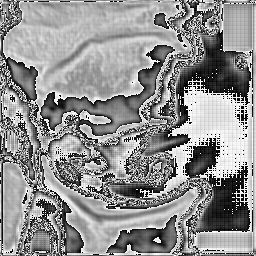

In [43]:
out=model(image_tensor[0][0].unsqueeze(0).unsqueeze(0).to(device))
to_pil=transforms.ToPILImage()
pil_image = to_pil(out.squeeze(0))
pil_image.convert('L') # output image of the model 

In [44]:
# Load and preprocess the fetal axial image
image = cv2.imread('/kaggle/input/image-dataset/images 2/000_HC.png', cv2.IMREAD_GRAYSCALE)
image = cv2.resize(image, (256, 256))  # Resize to match the U-Net input size
image = image.astype(np.float32) / 255.0  # Normalize the image
image_tensor = transforms.ToTensor()(image).unsqueeze(0)  # Convert to PyTorch tensor

In [45]:
with torch.no_grad():
    output = model(image_tensor[0][0].unsqueeze(0).unsqueeze(0).to(device))

# Convert the segmentation mask to binary (0 or 1)
segmentation_mask = torch.sigmoid(output) > 0.5
segmentation_mask = segmentation_mask.squeeze().cpu().numpy().astype(np.uint8)

In [46]:
edges = cv2.Canny(segmentation_mask, 30, 100)
edges.shape
# Find contours and extract biometry points (e.g., centroids of contours)
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
for contour in contours:
    M = cv2.moments(contour)
    if M["m00"] != 0:
        cx = int(M["m10"] / M["m00"])
        cy = int(M["m01"] / M["m00"])
        cv2.circle(image, (cx, cy), 3, (0, 255, 0), -1)  # Draw biometry points on the image

# Display the result
cv2.imshow('Result', image)
cv2.waitKey(0)
cv2.destroyAllWindows()

error: OpenCV(4.9.0) /io/opencv/modules/highgui/src/window.cpp:1272: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvShowImage'


In [ ]:
segmentation_mask.shape

In [ ]:
x=torch.randn(32,1,256,256)
x=x.to(device)
output=model(x)

In [ ]:
output.shape